In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from Dude import createSQL
import numpy as np

In [2]:
conn = sqlite3.connect('../data/homework_data.db')
c = conn.cursor()


# Solving the loading tasks

In [4]:
table = pd.read_sql_query(
    """
    SELECT route_id
            stop_sequence,
            stop_id,
            direction_id
            From trips
    Join stop_times 
    on (trips.trip_id = stop_times.trip_id)
    """
    ,
    conn
)

In [5]:
createSQL("t1",table, conn)

In [6]:
t2 = pd.read_sql_query(
    """
    SELECT 
    stop_id, COUNT(stop_id) as stop_count
    FROM trips
    Join stop_times on stop_times.trip_id = trips.trip_id
    group by (stop_id)
    ;


    """,conn)

In [7]:
createSQL("mynodes",t2, conn)

In [8]:
gdata = pd.read_sql_query(
    """
    SELECT stops.stop_id, stop_name, stop_lat, stop_lon, mynodes.stop_count
    FROM stops
    Join mynodes
    on stops.stop_id = mynodes.stop_id
    ;
    """
    ,conn)
createSQL("gdata",gdata, conn)

# Calculate degree distribution

In [20]:
frqeq = pd.read_sql_query(
    """
    SELECT stop_count, COUNT(stop_count) AS Frequency

  FROM gdata

  GROUP BY stop_count

  ORDER BY

  COUNT(stop_count) DESC
    ;
    """
    ,conn)



The average degree of distribution is 3.9823




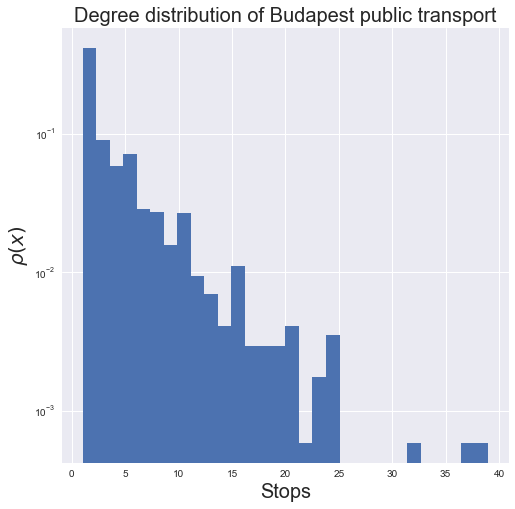

In [22]:
distr = frqeq.Frequency
plt.hist(distr, bins = 30, density=True)
plt.yscale("log")
plt.title("Degree distribution of Budapest public transport")
plt.ylabel(r"$\rho(x)$")
plt.xlabel("Stops")
print(f"""

The average degree of distribution is {np.mean(distr):.4f}

""")

# Clustering

## Average clust coeff

In [83]:
etable = pd.read_sql_query("""
    select 
    source,target,COUNT(target) + COUNT(target) as edges
    
    from df
    group by source
;""",conn)
createSQL("etable",etable, conn)

In [84]:
s2 = pd.read_sql_query("""
    select 
    A.edges, Count(B.source) as nes
    from etable A, etable B, etable C
    where (A.target = B.source or B.target = A.source) and (B.source = C.target or B.target = C.source) and (C.target = A.source or C.source = A.target)
    group by B.source
;""",conn)

## Global coeff

In [7]:
pd.read_sql_query("""
    select 
    
    A.source as first_stop,B.source as second_stop , C.source as third_stop, C.target
    
    from df A, df B, df C
    where A.target = B.source and B.target = C.source and C.target = A.source
;""",conn)

,first_stop,second_stop,third_stop,target
0,501. utca,Dombhát utca,Rézvirág utca,501. utca
1,501. utca,Jászberényi út,Dombhát utca,501. utca
2,501. utca,Rézvirág utca,Dombhát utca,501. utca
3,509. utca,513. utca,Borsó utca,509. utca
4,513. utca,Borsó utca,509. utca,513. utca
...,...,...,...,...
1985,Ősz utca,Elem utca,Újpesti Erőmű,Ősz utca
1986,Ősz utca,Gubacsi út / Határ út,Gubacsi út / Határ út,Ősz utca
1987,Ősz utca,Árpád út,Víztorony,Ősz utca
1988,Ősz utca,Árpád üzletház,Munkásotthon utca,Ősz utca


In [30]:
pd.read_sql_query("""
    select 
    
    A.stop_count, B.stop_count
    
    from df A, df B, df C
    where A.target = B.source and B.target = C.source and  (C.target = A.source or A.target = C.source)
    ;""",conn)

,stop_count,stop_count
0,1629,1773
1,1629,544
2,1629,2335
3,1629,3348
4,3348,2860
...,...,...
3874,132,569
3875,132,988
3876,237,109
3877,237,109


In [13]:
number_of_triangles = pd.read_sql_query("""
    select 
    
    COUNT(*) as value
    from df A, df B, df C
    where A.target = B.source and B.target = C.source and C.target = A.source
;""",conn)

In [14]:
number_of_triples = pd.read_sql_query("""
    select 
    
    COUNT(*) as value
    from df A, df B, df C
    where A.target = B.source and B.target = C.source
;""",conn)

In [81]:
glob_cof = (number_of_triangles.value* 3 ) /number_of_triples.value

sav = s2.nes*2 / ( s2.edges*(s2.edges-1))

print(f"""

The average clustering coefficient is {sav.mean():.4f}
The global clustering coefficient is: {glob_cof.values[0]:.4f}

""" )



The average clustering coefficient is 0.7171
The global clustering coefficient is: 0.0816




# Calculate correlation

In [39]:
to_pearson = pd.read_sql_query("""
SELECT DISTINCT A.source,A.stop_count as edges, B.target,B.stop_count as neighbour_edges
FROM df A, df B
Where A.target = B.target
group by
A.source

;""",conn)
createSQL("to_pearson",to_pearson, conn)

In [6]:
df = pd.read_sql_query("select edges, neighbour_edges from to_pearson",conn)

In [12]:
from scipy.stats import pearsonr
print(f"""

The clustering coefficint of the network is {pearsonr(df.edges,df.neighbour_edges)[0]}
It means this the graph is not assortativite.
Though I could've calculated it with sql, sql lite does not have the sqrt function (for some reaseon)
"""


)



The clustering coefficint of the network is 0.4843379815658244
Though I could've calculated it with sql, sql lite does not have the sqrt function (for some reaseon)



In [52]:
pd.read_sql_query("""

SELECT  
        -- For Population
        (avg(x * y) - avg(x) * avg(y)) / 
        (sqrt(avg(x * x) - avg(x) * avg(x)) * sqrt(avg(y * y) - avg(y) * avg(y))) 
        AS correlation_coefficient_population,
        -- For Sample
        (count(*) * sum(x * y) - sum(x) * sum(y)) / 
        (sqrt(count(*) * sum(x * x) - sum(x) * sum(x)) * sqrt(count(*) * sum(y * y) - sum(y) * sum(y))) 
        AS correlation_coefficient_sample
    FROM (
        SELECT to_pearson.edges AS x, 
                to_pearson.neighbour_edges AS y 
            FROM to_pearson
        )


""",conn)

DatabaseError: Execution failed on sql '

SELECT  
        -- For Population
        (avg(x * y) - avg(x) * avg(y)) / 
        (sqrt(avg(x * x) - avg(x) * avg(x)) * sqrt(avg(y * y) - avg(y) * avg(y))) 
        AS correlation_coefficient_population,
        -- For Sample
        (count(*) * sum(x * y) - sum(x) * sum(y)) / 
        (sqrt(count(*) * sum(x * x) - sum(x) * sum(x)) * sqrt(count(*) * sum(y * y) - sum(y) * sum(y))) 
        AS correlation_coefficient_sample
    FROM (
        SELECT to_pearson.edges AS x, 
                to_pearson.neighbour_edges AS y 
            FROM to_pearson
        )


': no such function: sqrt